#**스마트폰 센서 데이터 기반 모션 분류**
# 단계3 : 단계별 모델링


## 0.미션4

* 단계별로 나눠서 모델링을 수행하고자 합니다.  
* 단계 구분 예시
    * 단계1 : 정적(0), 동적(1) 행동 분류 모델 생성
    * 단계2 : 세부 동작에 대한 분류모델 생성
        * 단계1 모델에서 0으로 예측 -> 정적 행동 3가지 분류 모델링
        * 단계1 모델에서 1으로 예측 -> 동적 행동 3가지 분류 모델링
* (선택) 모델 통합
    * 두 단계 모델을 통합하고, 새로운 데이터에 대해서 최종 예측결과와 성능평가가 나오도록 함수로 만들기
* 성능 비교
    * 기본 모델링의 성능과 비교
    * 성능 가이드
        * Accuracy : 0.97 ~ 0.99
* (선택) 파이프라인 구성
    * test 데이터를 입력하여, 전처리 및 예측결과가 나오도록 함수 구성

## 1.환경설정

* 세부 요구사항
    - 경로 설정 : 구글콜랩
        * 구글 드라이브 바로 밑에 project3 폴더를 만들고,
        * 데이터 파일을 복사해 넣습니다.
    - 기본적으로 필요한 라이브러리를 import 하도록 코드가 작성되어 있습니다.
        * 필요하다고 판단되는 라이브러리를 추가하세요.


### (1) 경로 설정

* 구글 드라이브 연결

In [1]:
## 공통
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
## 공통
path = '/content/drive/MyDrive/project3/'

### (2) 라이브러리 불러오기

* 라이브러리 로딩
  - pandas, numpy,matplotlib,seaborn, joblib, 모델링에 필요한 라이브러리를 로딩합니다.

In [27]:
## 공통
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import joblib

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler
from sklearn.metrics import *

from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout, Input, BatchNormalization, Activation
from keras.backend import clear_session
from keras.optimizers import Adam

## 추가
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical

In [4]:
## 공통
# 학습곡선 함수
def dl_history_plot(history):
    plt.figure(figsize=(10,6))
    plt.plot(history['loss'], label='train_err', marker = '.')
    plt.plot(history['val_loss'], label='val_err', marker = '.')

    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid()
    plt.show()

### (3) 데이터 불러오기

* 주어진 데이터셋
    * data01_train.csv : 학습 및 검증용
    * data01_test.csv : 테스트용
    * feature.csv : feature 이름을 계층구조로 정리한 데이터

* 세부 요구사항
    * 칼럼 삭제 : data01_train.csv와 data01_test.csv 에서 'subject' 칼럼은 불필요하므로 삭제합니다.

#### 1) 데이터로딩

In [5]:
## 공통
# 주어진 데이터 셋을 불러오세요.(3개)
train_data = pd.read_csv(path + 'data01_train.csv')
test_data = pd.read_csv(path + 'data01_test.csv')
feature_data = pd.read_csv(path + 'features.csv')

In [6]:
## 공통
# 불필요한 칼럼을 삭제하세요.
train_data.drop('subject', axis=1, inplace=True)
test_data.drop('subject', axis=1, inplace=True)

#### 2) 기본 정보 조회

In [7]:
## 공통
# 전체 데이터의 행,열 개수 확인
print(train_data.shape)
print(test_data.shape)

(5881, 562)
(1471, 562)


In [8]:
## 공통
# 전체 데이터의 상위 5개 행 확인
display(train_data.head())

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",Activity
0,0.288508,-0.009196,-0.103362,-0.988986,-0.962797,-0.967422,-0.989000,-0.962596,-0.965650,-0.929747,...,-0.487737,-0.816696,-0.042494,-0.044218,0.307873,0.072790,-0.601120,0.331298,0.165163,STANDING
1,0.265757,-0.016576,-0.098163,-0.989551,-0.994636,-0.987435,-0.990189,-0.993870,-0.987558,-0.937337,...,-0.237820,-0.693515,-0.062899,0.388459,-0.765014,0.771524,0.345205,-0.769186,-0.147944,LAYING
2,0.278709,-0.014511,-0.108717,-0.997720,-0.981088,-0.994008,-0.997934,-0.982187,-0.995017,-0.942584,...,-0.535287,-0.829311,0.000265,-0.525022,-0.891875,0.021528,-0.833564,0.202434,-0.032755,STANDING
3,0.289795,-0.035536,-0.150354,-0.231727,-0.006412,-0.338117,-0.273557,0.014245,-0.347916,0.008288,...,-0.004012,-0.408956,-0.255125,0.612804,0.747381,-0.072944,-0.695819,0.287154,0.111388,WALKING
4,0.394807,0.034098,0.091229,0.088489,-0.106636,-0.388502,-0.010469,-0.109680,-0.346372,0.584131,...,-0.157832,-0.563437,-0.044344,-0.845268,-0.974650,-0.887846,-0.705029,0.264952,0.137758,WALKING_DOWNSTAIRS


In [9]:
## 공통
# 전체 데이터의 수치형 변수 분포 확인
display(train_data.describe())

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-meanFreq(),fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)"
count,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,...,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000,5881.000000
mean,0.274811,-0.017799,-0.109396,-0.603138,-0.509815,-0.604058,-0.628151,-0.525944,-0.605374,-0.465490,...,0.126955,-0.305883,-0.623548,0.008524,-0.001185,0.009340,-0.007099,-0.491501,0.059299,-0.054594
std,0.067614,0.039422,0.058373,0.448807,0.501815,0.417319,0.424345,0.485115,0.413043,0.544995,...,0.249176,0.322808,0.310371,0.339730,0.447197,0.608190,0.476738,0.509069,0.297340,0.278479
min,-0.503823,-0.684893,-1.000000,-1.000000,-0.999844,-0.999667,-1.000000,-0.999419,-1.000000,-1.000000,...,-0.965725,-0.979261,-0.999765,-0.976580,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-0.980143
25%,0.262919,-0.024877,-0.121051,-0.992774,-0.977680,-0.980127,-0.993602,-0.977865,-0.980112,-0.936067,...,-0.021610,-0.541969,-0.845985,-0.122361,-0.294369,-0.481718,-0.373345,-0.811397,-0.018203,-0.141555
50%,0.277154,-0.017221,-0.108781,-0.943933,-0.844575,-0.856352,-0.948501,-0.849266,-0.849896,-0.878729,...,0.133887,-0.342923,-0.712677,0.010278,0.005146,0.011448,-0.000847,-0.709441,0.182893,0.003951
75%,0.288526,-0.010920,-0.098163,-0.242130,-0.034499,-0.262690,-0.291138,-0.068857,-0.268539,-0.013690,...,0.288944,-0.127371,-0.501158,0.154985,0.285030,0.499857,0.356236,-0.511330,0.248435,0.111932
max,1.000000,1.000000,1.000000,1.000000,0.916238,1.000000,1.000000,0.967664,1.000000,1.000000,...,0.946700,0.989538,0.956845,1.000000,1.000000,0.998702,0.996078,0.977344,0.478157,1.000000


In [10]:
## 공통
# 전체 데이터의 모든 변수 확인
print(train_data.columns)
print('-'*100)
display(train_data.info())

Index(['tBodyAcc-mean()-X', 'tBodyAcc-mean()-Y', 'tBodyAcc-mean()-Z',
       'tBodyAcc-std()-X', 'tBodyAcc-std()-Y', 'tBodyAcc-std()-Z',
       'tBodyAcc-mad()-X', 'tBodyAcc-mad()-Y', 'tBodyAcc-mad()-Z',
       'tBodyAcc-max()-X',
       ...
       'fBodyBodyGyroJerkMag-skewness()', 'fBodyBodyGyroJerkMag-kurtosis()',
       'angle(tBodyAccMean,gravity)', 'angle(tBodyAccJerkMean),gravityMean)',
       'angle(tBodyGyroMean,gravityMean)',
       'angle(tBodyGyroJerkMean,gravityMean)', 'angle(X,gravityMean)',
       'angle(Y,gravityMean)', 'angle(Z,gravityMean)', 'Activity'],
      dtype='object', length=562)
----------------------------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5881 entries, 0 to 5880
Columns: 562 entries, tBodyAcc-mean()-X to Activity
dtypes: float64(561), object(1)
memory usage: 25.2+ MB


None

## 2.데이터 전처리

* 세부 요구사항
    - Label 추가 : 1단계 모델을 위한 레이블 추가
    - train : val = 8 : 2 혹은 7 : 3
    - random_state 옵션을 사용하여 다른 모델과 비교를 위해 성능이 재현되도록 합니다.

### (1) 1단계 모델링을 위한 레이블

In [11]:
## 정적, 움직임 리스트 추가
dynamic = ['WALKING', 'WALKING_DOWNSTAIRS', 'WALKING_UPSTAIRS']
static = ['STANDING', 'SITTING', 'LAYING']

# Lable 추가(1단계 모델:정적(0), 동적(1) 행동 분류 모델 생성 )
train_data['is_dynamic'] = train_data['Activity'].apply(lambda x: 0 if x in static else 1)
print(train_data['is_dynamic'].value_counts())

is_dynamic
0    3234
1    2647
Name: count, dtype: int64


### (2) x, y 분리

In [12]:
# x,y 분리하기
x = train_data.drop(['is_dynamic', 'Activity'], axis=1)
y = train_data['is_dynamic']

### (3) 스케일링


* 세부 요구사항
    - 스케일링을 필요로 하는 알고리즘 사용을 위해서 코드 수행
    - min-max 방식 혹은 standard 방식 중 한가지 사용.

In [13]:
# 스케일링 방식을 선택해서 스케일링을 진행합니다.
scaler = StandardScaler()
x = scaler.fit_transform(x)

### (4) 데이터 분할
* train, val 분할

In [14]:
# 데이터 분할 진행(train:val = 8:2 혹은 7:3 권장)
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=42)

## **3.단계별 모델링**

### (1) 단계1

* 세부 요구사항
    * 적절한 단계로 구분한 후, 1단계를 분류하는 모델 생성
        * 예시 : 정적 행동(Laying, Sitting, Standing)과 동적 행동(동적 : Walking, Walking-Up, Walking-Down)을 구분하는 모델 생성.
    * 몇 가지 모델을 만들고 가장 성능이 좋은 모델을 선정하시오.(기본 모델링 참고)

#### 1) 모델1

In [15]:
# 모델 설계
n_feature = x_train.shape[1]

is_model = Sequential([
     Input(shape=(n_feature,)),
     Dense(128, activation='relu'),
     Dense(64, activation='relu'),
     Dense(32, activation='relu'),
     Dense(1, activation='sigmoid')
])

is_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │        71,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 82,305 (321.50 KB)

 Trainable params: 82,305 (321.50 KB)

 Non-trainable params: 0 (0.00 B)

In [16]:
# 컴파일 및 학습
is_model.compile(
    loss='binary_crossentropy',
    optimizer=Adam(learning_rate=0.001),
    metrics=['accuracy']
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

history = is_model.fit(
    x_train,
    y_train,
    validation_data=(x_val, y_val),
    epochs=20,
    batch_size=32,
    callbacks=[early_stopping]
)

Epoch 1/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.9886 - loss: 0.0486 - val_accuracy: 1.0000 - val_loss: 1.4225e-04
Epoch 2/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 1.0000 - loss: 1.6919e-04 - val_accuracy: 1.0000 - val_loss: 8.0448e-05
Epoch 3/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 1.0000 - loss: 5.3314e-05 - val_accuracy: 1.0000 - val_loss: 7.3545e-05
Epoch 4/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 1.0000 - loss: 1.4793e-05 - val_accuracy: 1.0000 - val_loss: 4.3413e-05
Epoch 5/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 1.0000 - loss: 1.2888e-05 - val_accuracy: 1.0000 - val_loss: 2.8561e-05
Epoch 6/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 1.0000 - loss: 4.8345e-06 - val_accuracy: 1.0000 - val_loss: 2.0335e-05
Epoch 7/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 1.0000 - loss: 2.5851e-06 - val_accuracy: 1.0000 - val_loss: 1.6348e-05
Epoch 8/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step 

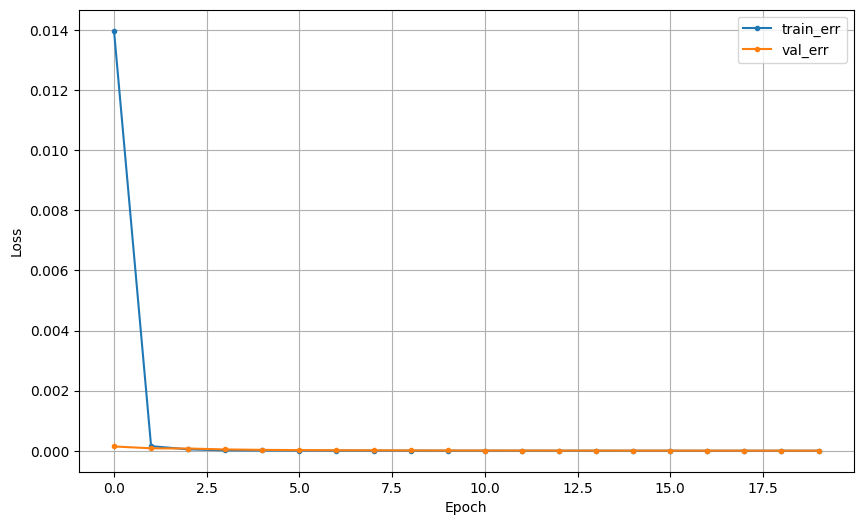

In [17]:
# 학습곡선
dl_history_plot(history.history)

In [18]:
# 예측 및 평가
y_pred = is_model.predict(x_val)
y_pred = np.where(y_pred > 0.5, 1, 0)
print(classification_report(y_val, y_pred))
print('-'*100)
print('Accuray :', accuracy_score(y_val, y_pred))

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       657
           1       1.00      1.00      1.00       520

    accuracy                           1.00      1177
   macro avg       1.00      1.00      1.00      1177
weighted avg       1.00      1.00      1.00      1177

----------------------------------------------------------------------------------------------------
Accuray : 1.0


#### 2) 모델2

In [19]:
# 모델 설계
rf_is_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)

In [20]:
# 컴파일 및 학습
rf_is_model.fit(x_train, y_train)

RandomForestClassifier(n_jobs=-1, random_state=42)

In [21]:
# 검증
y_pred_rf = rf_is_model.predict(x_val)

In [22]:
# 예측 및 평가
print(classification_report(y_val, y_pred_rf, target_names=["Static", "Dynamic"]))
print('-'*100)
print("✅ RandomForest (is_model) Accuracy:", accuracy_score(y_val, y_pred_rf))

              precision    recall  f1-score   support

      Static       1.00      1.00      1.00       657
     Dynamic       1.00      1.00      1.00       520

    accuracy                           1.00      1177
   macro avg       1.00      1.00      1.00      1177
weighted avg       1.00      1.00      1.00      1177

----------------------------------------------------------------------------------------------------
✅ RandomForest (is_model) Accuracy: 1.0


### (2) 단계2

#### 1) 단계2-1 : 정적 동작 세부 분류

* 세부 요구사항
    * 정적 행동(Laying, Sitting, Standing)인 데이터 추출
    * Laying, Sitting, Standing 를 분류하는 모델을 생성
    * 몇가지 모델을 만들고 가장 성능이 좋은 모델을 선정하시오.

In [23]:
# (tip) 정적 행동(0)인 데이터 추출
static_data = train_data[train_data['is_dynamic'] == 0].copy()
display(static_data.head())

## x, y 분리
x_static = static_data.drop(['Activity', 'is_dynamic'], axis=1)
y_static = static_data['Activity']

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",Activity,is_dynamic
0,0.288508,-0.009196,-0.103362,-0.988986,-0.962797,-0.967422,-0.989000,-0.962596,-0.965650,-0.929747,...,-0.816696,-0.042494,-0.044218,0.307873,0.072790,-0.601120,0.331298,0.165163,STANDING,0
1,0.265757,-0.016576,-0.098163,-0.989551,-0.994636,-0.987435,-0.990189,-0.993870,-0.987558,-0.937337,...,-0.693515,-0.062899,0.388459,-0.765014,0.771524,0.345205,-0.769186,-0.147944,LAYING,0
2,0.278709,-0.014511,-0.108717,-0.997720,-0.981088,-0.994008,-0.997934,-0.982187,-0.995017,-0.942584,...,-0.829311,0.000265,-0.525022,-0.891875,0.021528,-0.833564,0.202434,-0.032755,STANDING,0
7,0.272026,-0.001329,-0.125491,-0.992068,-0.912985,-0.972451,-0.994752,-0.943141,-0.976428,-0.925446,...,-0.704995,-0.024442,0.076332,0.741277,0.729812,-0.817201,0.037746,0.136129,STANDING,0
8,0.284338,0.021956,-0.006925,-0.980153,-0.838394,-0.782357,-0.983683,-0.816199,-0.743923,-0.914011,...,-0.400197,0.021212,-0.009465,-0.282762,0.563343,-0.782072,0.242834,-0.025285,STANDING,0


In [24]:
# (tip) 인코딩 진행, map 활용해서 숫자레이블로 매핑
static_activity_map = {'LAYING': 0, 'SITTING': 1, 'STANDING': 2}
y_static = y_static.map(static_activity_map)
y_static_onehot = to_categorical(y_static)

## 확인
print(y_static_onehot)

[[0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 ...
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]]


In [25]:
## 기존에 썼던 scaler 재사용 가능
x_static_scaled = scaler.transform(x_static)

## 데이터 분할
x_train_s, x_val_s, y_train_s, y_val_s = train_test_split(x_static_scaled, y_static_onehot, test_size=0.2, random_state=42)

In [28]:
# 모델 설계
static_model = Sequential([
    Input(shape=(x_train_s.shape[1],)),
    Dense(256),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.4),
    Dense(128),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.3),
    Dense(64),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.2),
    Dense(32),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.2),
    Dense(3, activation='softmax')  # 다중 클래스 분류
])

In [50]:
# 컴파일 및 학습
static_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=7,
    restore_best_weights=True
)

history = static_model.fit(
    x_train_s,
    y_train_s,
    validation_data=(x_val_s, y_val_s),
    epochs=30,
    batch_size=32,
    callbacks=[early_stopping]
)

Epoch 1/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 10s 46ms/step - accuracy: 0.9761 - loss: 0.0695 - val_accuracy: 0.9614 - val_loss: 0.1351
Epoch 2/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9778 - loss: 0.0819 - val_accuracy: 0.9722 - val_loss: 0.0899
Epoch 3/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9746 - loss: 0.0779 - val_accuracy: 0.9691 - val_loss: 0.1114
Epoch 4/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9712 - loss: 0.0859 - val_accuracy: 0.9304 - val_loss: 0.2038
Epoch 5/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9855 - loss: 0.0499 - val_accuracy: 0.9583 - val_loss: 0.1076
Epoch 6/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9798 - loss: 0.0649 - val_accuracy: 0.9366 - val_loss: 0.1846
Epoch 7/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9784 - loss: 0.0660 - val_accuracy: 0.9320 - val_loss: 0.1942
Epoch 8/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9838 - loss: 0.0600 - val_accuracy: 0.9691 - val_los

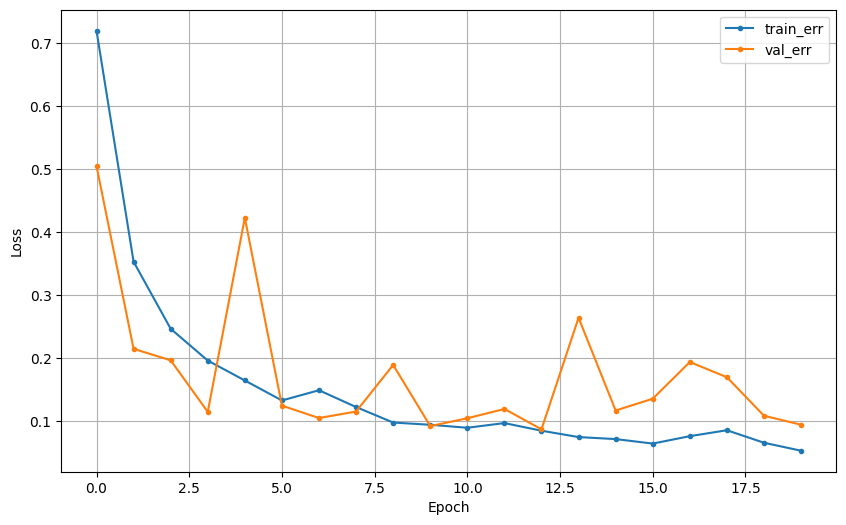

In [30]:
# 학습곡선
dl_history_plot(history.history)

In [31]:
# 예측 및 평가
y_pred = static_model.predict(x_val_s)
y_pred = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_val_s, axis=1)
print(classification_report(y_true, y_pred))
print('-'*100)
print('Accuray :', accuracy_score(y_true, y_pred))

21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       221
           1       0.94      0.98      0.96       205
           2       0.98      0.95      0.96       221

    accuracy                           0.98       647
   macro avg       0.97      0.98      0.97       647
weighted avg       0.98      0.98      0.98       647

----------------------------------------------------------------------------------------------------
Accuray : 0.9752704791344667


#### 2) 단계2-2 : 동적 동작 세부 분류

* 세부 요구사항
    * 동적 행동(Walking, Walking Upstairs, Walking Downstairs)인 데이터 추출
    * Walking, Walking Upstairs, Walking Downstairs 를 분류하는 모델을 생성
    * 몇가지 모델을 만들고 가장 성능이 좋은 모델을 선정하시오.

In [32]:
# (tip) 동적 행동(1)인 데이터 추출
dynamic_data = train_data[train_data['is_dynamic'] == 1].copy()
display(dynamic_data.head())

x_dynamic = dynamic_data.drop(['Activity', 'is_dynamic'], axis=1)
y_dynamic = dynamic_data['Activity']

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",Activity,is_dynamic
3,0.289795,-0.035536,-0.150354,-0.231727,-0.006412,-0.338117,-0.273557,0.014245,-0.347916,0.008288,...,-0.408956,-0.255125,0.612804,0.747381,-0.072944,-0.695819,0.287154,0.111388,WALKING,1
4,0.394807,0.034098,0.091229,0.088489,-0.106636,-0.388502,-0.010469,-0.109680,-0.346372,0.584131,...,-0.563437,-0.044344,-0.845268,-0.974650,-0.887846,-0.705029,0.264952,0.137758,WALKING_DOWNSTAIRS,1
5,0.330708,0.007561,-0.061371,-0.215760,0.101075,0.072949,-0.269857,0.060060,0.101298,-0.019263,...,-0.887024,-0.030645,-0.852091,-0.500195,0.306091,-0.552729,0.253885,0.291256,WALKING_UPSTAIRS,1
6,0.121465,-0.031902,-0.005196,-0.152198,-0.113104,-0.239423,-0.202401,-0.164698,-0.247099,0.114668,...,-0.775779,0.445206,-0.003487,-0.940185,0.041387,-0.886603,0.173338,-0.005627,WALKING,1
12,0.303885,0.002768,-0.038613,-0.168656,0.190336,-0.140473,-0.205134,0.101144,-0.120572,-0.000818,...,-0.329728,-0.040030,0.257252,0.076091,-0.123425,-0.752882,0.266729,0.045692,WALKING,1


In [33]:
# (tip) 인코딩 진행, map 활용해서 숫자레이블로 매핑
dynamic_activity_map = {'WALKING': 0, 'WALKING_UPSTAIRS': 1, 'WALKING_DOWNSTAIRS': 2}
y_dynamic = y_dynamic.map(dynamic_activity_map)
y_dynamic_onehot = to_categorical(y_dynamic)

## 확인
print(y_dynamic_onehot)

[[1. 0. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 ...
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]]


In [34]:
## 기존에 썼던 scaler 재사용 가능
x_dynamic_scaled = scaler.transform(x_dynamic)

## 데이터 분할
x_train_d, x_val_d, y_train_d, y_val_d = train_test_split(x_dynamic_scaled, y_dynamic_onehot, test_size=0.2, random_state=42)

In [35]:
# 모델 설계
n_feature = x_train_d.shape[1]

dynamic_model = Sequential([
    Input(shape=(n_feature,)),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(3, activation='softmax')  ## 다중 클래스 분류
])

In [36]:
# 컴파일 및 학습
dynamic_model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=0.001),
    metrics=['accuracy']
)

dynamic_history = dynamic_model.fit(
    x_train_d,
    y_train_d,
    validation_data=(x_val_d, y_val_d),
    epochs=20,
    batch_size=32,
    callbacks=early_stopping
)

Epoch 1/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.8002 - loss: 0.4966 - val_accuracy: 0.9679 - val_loss: 0.0796
Epoch 2/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9896 - loss: 0.0388 - val_accuracy: 0.9755 - val_loss: 0.0614
Epoch 3/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9910 - loss: 0.0303 - val_accuracy: 0.9925 - val_loss: 0.0230
Epoch 4/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9986 - loss: 0.0057 - val_accuracy: 0.9943 - val_loss: 0.0168
Epoch 5/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9933 - loss: 0.0168 - val_accuracy: 0.9660 - val_loss: 0.0851
Epoch 6/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9982 - loss: 0.0099 - val_accuracy: 0.9906 - val_loss: 0.0198
Epoch 7/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 8.5208e-04 - val_accuracy: 0.9925 - val_loss: 0.0141
Epoch 8/20
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 1.0000 - loss: 3.9664e-04 - val_accuracy: 0.9925 - 

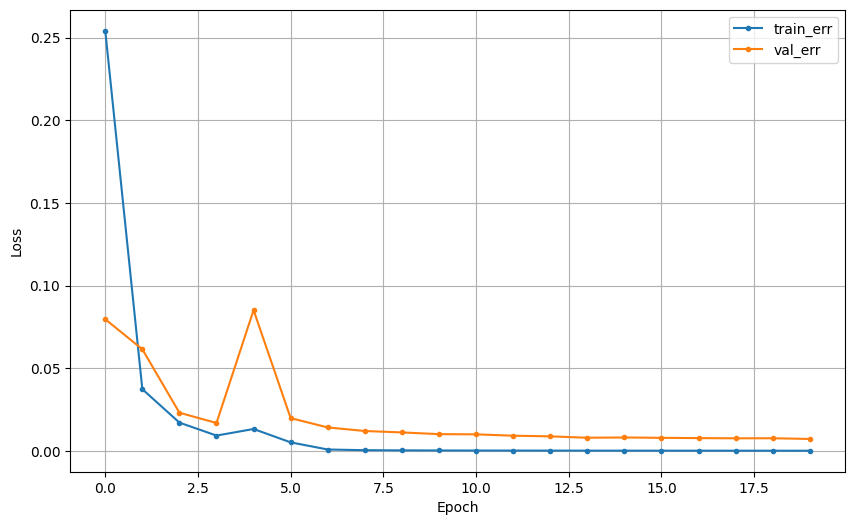

In [37]:
# 학습곡선
dl_history_plot(dynamic_history.history)

In [38]:
# 예측 및 평가
y_pred = dynamic_model.predict(x_val_d)
y_pred = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_val_d, axis=1)
print(classification_report(y_true, y_pred))
print('-'*100)
print('Accuray :', accuracy_score(y_true, y_pred))

17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       196
           1       0.98      1.00      0.99       171
           2       1.00      0.99      0.99       163

    accuracy                           0.99       530
   macro avg       0.99      0.99      0.99       530
weighted avg       0.99      0.99      0.99       530

----------------------------------------------------------------------------------------------------
Accuray : 0.9943396226415094


### (3) (옵션) 분류 모델 파이프라인 구성


* 세부 요구사항
    * 두 단계 모델을 통합하고, 새로운 데이터(test)에 대해서 최종 예측결과와 성능평가가 나오도록 함수로 만들기
    * 데이터 파이프라인 구축 : test데이터가 로딩되어 전처리 과정을 거치고, 예측 및 성능 평가 수행

* 예시
![](https://github.com/DA4BAM/image/blob/main/pipeline%20function.png?raw=true)

#### 1) 함수 만들기

In [39]:
#(tip) 함수 만들기
# 1. 전처리
# 1-1. 스케일링
# 1-2. 입력값 만들기
#-------------------
# 2. 예측하기
# 2-1. 단계1을 모델로 0,1 구분
# 2-2. 단계 1의 결과로 데이터 나누기
# 2-3. 단계2 모델로 예측
# 2-4. 예측 결과 원래 값으로 변환
# 2-5. 하나로 합쳐보기
#-------------------
# 3. 최종 성능평가 하기

In [40]:
# (옵션) 위 참고해서 분류모델 파이프라인 만들어보기
# 라벨 매핑 (static + dynamic)
static_map_rev = {0: 'LAYING', 1: 'SITTING', 2: 'STANDING'}
dynamic_map_rev = {0: 'WALKING', 1 : 'WALKING_UPSTAIRS', 2 : 'WALKING_DOWNSTAIRS'}

def final_predict(test_df, model1, model2_1, model2_2, scaler):
    df = test_df.copy()

    # 1. 전처리 ----------------------------
    y_true = df['Activity'].values  # 실제 라벨
    df.drop(['subject'], axis=1, inplace=True)

    # 1-1. 단계1용 is_dynamic 생성
    df['is_dynamic'] = df['Activity'].apply(lambda x: 0 if x in static else 1)

    # 1-2. X만 추출 + 스케일링
    x = df.drop(['Activity', 'is_dynamic'], axis=1)
    x_scaled = scaler.transform(x)

    # 2. 예측 ----------------------------
    # 2-1. 단계1: 정적/동적 분류
    pred_stage1 = model1.predict(x_scaled)
    pred_stage1 = np.where(pred_stage1 > 0.5, 1, 0)  # sigmoid 출력 처리

    # 2-2. 정적/동적으로 분할
    idx_static = np.where(pred_stage1 == 0)[0]
    idx_dynamic = np.where(pred_stage1 == 1)[0]

    x_static = x_scaled[idx_static]
    x_dynamic = x_scaled[idx_dynamic]

    # 2-3. 세부 분류
    pred_static = model2_1.predict(x_static)
    pred_static = np.argmax(pred_static, axis=1)

    pred_dynamic = model2_2.predict(x_dynamic)
    pred_dynamic = np.argmax(pred_dynamic, axis=1)

    # 2-4. 숫자 → 문자 복원
    pred_static_label = [static_map_rev[p] for p in pred_static]
    pred_dynamic_label = [dynamic_map_rev[p] for p in pred_dynamic]

    # 2-5. 최종 결과 합치기
    y_pred_final = np.empty(len(df), dtype=object)
    y_pred_final[idx_static] = pred_static_label
    y_pred_final[idx_dynamic] = pred_dynamic_label

    # 3. 평가 ----------------------------
    print("\n Classification Report:\n", classification_report(y_true, y_pred_final))
    print('-'*100)
    print("Accuracy :", accuracy_score(y_true, y_pred_final))

    return y_pred_final

#### 2) test 셋으로 예측하고 평가하기

In [41]:
# test 셋의 구조 한번 확인해보고 성능평가 해보기

In [42]:
test_data = pd.read_csv(path + 'data01_test.csv')

In [43]:
test_data.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",subject,Activity
0,0.284379,-0.021981,-0.116683,-0.992490,-0.979640,-0.963321,-0.992563,-0.977304,-0.958142,-0.938850,...,-0.850065,-0.018043,0.092304,0.074220,-0.714534,-0.671943,-0.018351,-0.185733,22,SITTING
1,0.277440,-0.028086,-0.118412,-0.996620,-0.927676,-0.972294,-0.997346,-0.931405,-0.971788,-0.939837,...,-0.613367,-0.022456,-0.155414,0.247498,-0.112257,-0.826816,0.184489,-0.068699,15,STANDING
2,0.305833,-0.041023,-0.087303,0.006880,0.182800,-0.237984,0.005642,0.028616,-0.236474,0.016311,...,0.394388,-0.362616,0.171069,0.576349,-0.688314,-0.743234,0.272186,0.053101,22,WALKING
3,0.276053,-0.016487,-0.108381,-0.995379,-0.983978,-0.975854,-0.995877,-0.985280,-0.974907,-0.941425,...,-0.841455,0.289548,0.079801,-0.020033,0.291898,-0.639435,-0.111998,-0.123298,8,SITTING
4,0.271998,0.016904,-0.078856,-0.973468,-0.702462,-0.869450,-0.979810,-0.711601,-0.856807,-0.920760,...,0.214219,0.010111,0.114179,-0.830776,-0.325098,-0.840817,0.116237,-0.096615,5,STANDING


In [44]:
test_data.shape

(1471, 563)

In [51]:
y_pred = final_predict(test_data, model1=rf_is_model, model2_1=static_model, model2_2=dynamic_model, scaler=scaler)

27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 

 Classification Report:
                     precision    recall  f1-score   support

            LAYING       1.00      1.00      1.00       292
           SITTING       0.97      0.93      0.95       254
          STANDING       0.94      0.97      0.96       287
           WALKING       0.99      1.00      1.00       228
WALKING_DOWNSTAIRS       1.00      1.00      1.00       195
  WALKING_UPSTAIRS       1.00      0.99      1.00       215

          accuracy                           0.98      1471
         macro avg       0.98      0.98      0.98      1471
      weighted avg       0.98      0.98      0.98      1471

----------------------------------------------------------------------------------------------------
Accuracy : 0.9809653297076818
